In [ ]:
%pip install mabwiser

In [1]:
from mabwiser.mab import MAB, LearningPolicy, NeighborhoodPolicy
import numpy as np
import pandas as pd
from itertools import permutations 
import matplotlib.pyplot as plt
import heapq
from scipy.stats import uniform
import random
from sklearn.preprocessing import StandardScaler

In [112]:
# Utility functions

def permutation(possibilities, length):
    perm = permutations(possibilities, length) 
    return list(perm)

def truncate(value, min=0, max=1):
    if (value < min): value = min
    if (value > max): value = max
    return value

def sample_gaussian(loc=0.5, scale=0.5, size=1):
    result = np.random.normal(loc=loc, scale=scale, size=size)
    for i in range(len(result)):
        result[i] = truncate(result[i])
    return result

In [120]:
sample_gaussian()

array([1.])

(array([175570.,  17639.,  18923.,  19737.,  20695.,  21560.,  22435.,
         23294.,  24284.,  24800.,  25332.,  25874.,  26476.,  26579.,
         26441.,  26370.,  26553.,  26387.,  25931.,  25455.,  24568.,
         24250.,  23751.,  22389.,  21596.,  20943.,  19753.,  18708.,
         17781., 175926.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

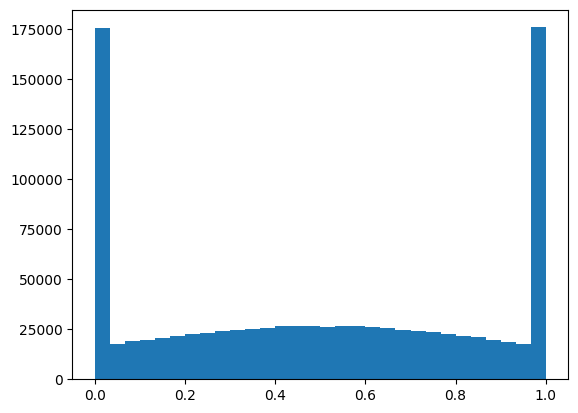

In [111]:
plt.hist(sample_gaussian(loc=0.5, scale=0.5, size=1000000), bins=30)

In [137]:
# Iterated Boolean Game

class IteratedBooleanGame:
    # A constructor where initial boolean variable states are passed
    def __init__(self, vars):
        self.evolution = []
        self.evolution.append(vars)
        self.agents = []
        self.message_queue = []
        self.master_clk = 0
        self.phi_matched = 0
        self.psi_matched = 0

    # Check if a subset (from start to stop) satisfies phi LTL
    # Return the details of the first-matched message sequence
    def check_phi(self, start, stop):
        seq_start = -1
        initial_found = False # Found (F, F)
        for i in range(start, stop + 1):
            if self.evolution[i] == (False, False):
                initial_found = True
                seq_start = i
            if initial_found and self.evolution[i] == (True, False) and (i + 1) <= stop:
                if self.evolution[i + 1] == (True, True):
                    return {"result": True, "seq_start": seq_start, "seq_end": i + 1} # Phi matched
        return {"result": False, "seq_start": -1, "seq_end": -1} # Phi not matched
    
    # Similar to the check_phi one but for psi LTL
    def check_psi(self, start, stop):
        seq_start = -1
        initial_satisfied = False # Found (F, F) -> X(F, T)
        for i in range(start, stop + 1):
            if self.evolution[i] == (False, False) and (i + 1) <= stop:
                if self.evolution[i + 1] == (False, True):
                    initial_satisfied = True
                    seq_start = i
            if initial_satisfied and self.evolution[i] == (True, True):
                return {"result": True, "seq_start": seq_start, "seq_end": i} # Psi matched
        return {"result": False, "seq_start": -1, "seq_end": -1} # Psi not matched

    # Count the number of times phi LTL is satisfied in the evolution
    def phi_count(self):
        if (len(self.evolution) == 0):
            return 0
        result = 0
        r = self.check_phi(0, len(self.evolution) - 1)
        while r["result"]:
            result += 1
            next_start = r["seq_end"] + 1
            if (next_start >= len(self.evolution) or next_start == -1):
                break
            r = self.check_phi(next_start, len(self.evolution) - 1)
        return result
    
    # Count the number of times psi LTL is satisfied in the evolution
    def psi_count(self):
        if (len(self.evolution) == 0):
            return 0
        result = 0
        r = self.check_psi(0, len(self.evolution) - 1)
        while r["result"]:
            result += 1
            next_start = r["seq_end"] + 1
            if (next_start >= len(self.evolution) or next_start == -1):
                break
            r = self.check_psi(next_start, len(self.evolution) - 1)
        return result
    
    # A method to add agent to the game
    def add_agent(self, agent):
        self.agents.append(agent)
        
    # A method to start running simulation
    def simulate(self, max_time=10, timestep_log=False):

        # Clear previous result from the last simulation
        self.evolution = self.evolution[:1]
        self.message_queue = []
        self.master_clk = 0

        print("### Running Iterated Boolean Game Simulation ###")

        # At time step t = 0
        if timestep_log:
            print(f'> t = {self.master_clk:.2f} | {self.evolution[-1]} | Phi: {self.phi_matched} | Psi: {self.psi_matched}')

        # For every non-negative integer time step i.e., t = 0, 1, 2, 3, ...
        for t in range(max_time):
            # Update the game master clock
            self.master_clk = t

            # Receive message from each agent in the game
            for a in self.agents:
                m = a.get_message()
                exe_time = self.master_clk + sample_gaussian()[0] # Add message latency ~ N(μ, σ)
                if m:
                    heapq.heappush(self.message_queue, (exe_time, m)) # If message exists, add it to the message queue
            
            # Process each message in the queue 
            while len(self.message_queue) > 0:
                if (self.message_queue[0][0] >= t and self.message_queue[0][0] < t + 1):
                    m = heapq.heappop(self.message_queue) # Message = (Time, (Var Idx, Val))
                    self.master_clk = m[0]
                    to_process = [m]
                    while len(self.message_queue) > 0 and self.message_queue[0][0] == m[0]:
                        m_matched = heapq.heappop(self.message_queue)
                        to_process.append(m_matched)
                    new_state = list(self.evolution[-1])
                    m_chosen = to_process[random.randint(0, len(to_process) - 1)]
                    new_state[m_chosen[1][0]] = m_chosen[1][1]
                    new_state = tuple(new_state)
                    self.evolution.append(new_state)

                    # Update phi_matched & psi_matched. However, this is not the most efficient way to do so, 
                    # will be improved in the next version
                    self.phi_matched = self.phi_count() 
                    self.psi_matched = self.psi_count()
                    if timestep_log:
                        print(f'> t = {self.master_clk:.2f} | {self.evolution[-1]} | Phi: {self.phi_matched} | Psi: {self.psi_matched}')
                else:
                    break

            # Each agent learns
            for a in self.agents:
                a.learn(self.phi_matched, self.psi_matched)
                
        print("#" * 30)    

    # A method to explain latest simulation
    def explain(self):
        print("### Explaining Latest Iterated Boolean Game Simulation ###")
        print(self.evolution)
        print(f'Phi Satisfaction Count: {self.phi_count()}')
        print(f'Psi Satisfaction Count: {self.psi_count()}')
        print("#" * 30)  


## Agent types to test gameplay performance

In [ ]:
# Agent message string lookup for debugging purpose
arms_to_message = {'A->T': (0, True), 'A->F': (0, False), 'B->T': (1, True), 'B->F': (1, False)}

### 1. Randomizing Agent

In [135]:
class RandomizeAgent:
    def __init__(self, internal_latency, objective):
        self.internal_latency = internal_latency
        self.objective = objective
        self.message_sent = []

    def get_message(self):
        s = [(0, False), (1, False), (0, True), (1, True)]
        m = s[random.randint(0, 3)]
        self.message_sent.append(m)
        return m

    def learn(self, phi_matched, psi_matched):
        return

In [ ]:
game1 = IteratedBooleanGame((False, False))
r_agent1 = RandomizeAgent(0, "phi")
r_agent2 = RandomizeAgent(0, "psi")
game1.add_agent(r_agent1)
game1.add_agent(r_agent2)
game1.simulate(max_time=10000)
game1.explain()

### Running Iterated Boolean Game Simulation ###
##############################
### Explaining Latest Iterated Boolean Game Simulation ###
[(False, False), (False, True), (False, True), (False, True), (False, True), (False, True), (False, True), (True, True), (True, False), (True, False), (True, False), (False, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (False, False), (False, True), (False, True), (False, True), (False, True), (False, False), (False, True), (False, False), (False, False), (False, False), (True, False), (True, True), (True, False), (True, False), (False, False), (True, False), (False, False), (False, True), (False, True), (False, False), (False, True), (False, True), (False, False), (False, False), (False, False), (False, False), (False, True), (False, False), (False, False), (True, False), (True, False), (True, False), (True, True), (True, True), (True, True), (True, True), (True, False), (True, False), (False, Fa

### 2. Circular Agent

In [143]:
class CircularAgent:
    def __init__(self, internal_latency, objective):
        self.internal_latency = internal_latency
        self.objective = objective
        self.message_sent = []
        self.i = -1

    def get_message(self):
        self.i += 1
        s = []
        if self.objective == "phi":
            s = [(0, False), (1, False), (0, True), (1, True), (0, False), (1, False)]
        elif self.objective == "psi":
            s = [(0, False), (1, False), (1, True), (0, True), (0, False), (1, False)]
        m = s[self.i % 6]
        self.message_sent.append(m)
        return m

    def learn(self, phi_matched, psi_matched):
        return

In [144]:
game2 = IteratedBooleanGame((False, False))
c_agent1 = CircularAgent(0, "phi")
c_agent2 = CircularAgent(0, "psi")
game2.add_agent(c_agent1)
game2.add_agent(c_agent2)
game2.simulate(max_time=10000)
game2.explain()

### Running Iterated Boolean Game Simulation ###
##############################
### Explaining Latest Iterated Boolean Game Simulation ###
[(False, False), (False, False), (False, False), (False, False), (False, False), (False, True), (True, True), (True, True), (True, True), (False, True), (False, True), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, True), (True, True), (True, True), (True, True), (False, True), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, True), (True, True), (True, True), (True, True), (False, True), (False, True), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, True), (True, True), (True, True), (True, True), (False, True), (False, True), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, True), (True, True), (True, True), (False, True), (Fals

### 3. Naive MAB Agent

In [147]:
# Agent Class each with MAB

class NaiveAgent:
    def __init__(self, internal_latency, objective, mab):
        self.internal_latency = internal_latency
        self.objective = objective
        self.mab = mab
        self.message_sent = []
        self.times_matched = 0

    def get_message(self):
        arm_picked = self.mab.predict()
        self.message_sent.append(arm_picked)
        return arms_to_message[arm_picked]

    def learn(self, phi_matched, psi_matched):
        if (self.objective == "phi"):
            self.mab.partial_fit([self.message_sent[-1]], [phi_matched - self.times_matched])
        elif (self.objective == "psi"):
            self.mab.partial_fit([self.message_sent[-1]], [psi_matched - self.times_matched])

In [148]:
arms = ['A->T', 'A->F', 'B->T', 'B->F']
mab1 = MAB(arms, LearningPolicy.EpsilonGreedy(epsilon=0.8))
mab1.fit([], [])
mab2 = MAB(arms, LearningPolicy.EpsilonGreedy(epsilon=0.8))
mab2.fit([], [])


game = IteratedBooleanGame((False, False))
a1 = NaiveAgent(0, "phi", mab1)
a2 = NaiveAgent(0, "psi", mab2)
game.add_agent(a1)
game.add_agent(a2)

game.simulate(10000)
game.explain()

### Running Iterated Boolean Game Simulation ###
##############################
### Explaining Latest Iterated Boolean Game Simulation ###
[(False, False), (False, True), (False, True), (False, True), (False, True), (False, True), (True, True), (True, True), (False, True), (False, True), (True, True), (True, False), (True, False), (True, False), (True, True), (True, True), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, True), (True, True), (True, True), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, False), (True, True), (True, True), (True, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, False), (False, True), (True, True), (True, True), (True, True), (True, Fals

In [146]:
game = IteratedBooleanGame((False, False))
a1 = NaiveAgent(0, "phi")
game.add_agent(a1)
game.simulate(1000)
game.explain()
# [(0, False), (1, False), (0, True), (1, True), (0, False), (1, False)]

TypeError: __init__() missing 1 required positional argument: 'mab'

### 4. 2^n Bandits Agent

- Let there be 2^n bandits where each bandit represents one distinct possible state of variables.
- In this case, there are 4 bandits to represent (T, T), (T, F), (F, T) and (F, F).
- For each bandit, there are 2^n arm each represents all possible message responses.
- In this case, each bandit has 4 arms namely, A->T, A->F, B->T and B->F.
- Agent check current state of variables, pick the bandit, then call its predicted best response.
- For bandit reward learning, take φ as an example. In case of φ: (FF) -> F(TF) -> X(TT), satisfying φ has variables evolving to (TT) as a necessary condition.
- Whenever (TT) is reached, all of states in the sequence starting from (TT) tracing back to first matching (FF) are learned with the reward of 1.
- On the other hand to learn the reward of 0, all of states in the sequence starting from the state before aforementioned first matching (FF) tracing back to the next first matching (FF) are learned with the reward of 0.
- Also, when the path leading to X(TT) is deemed impossible, the previous attempt states are learned with the reward of 0 too. E.g. (FF) -> (TF) -> (FF) 

In [ ]:
# Running Simulation

# MAB Initialization
arms = ['A->T', 'A->F', 'B->T', 'B->F']
mab1 = MAB(arms, LearningPolicy.EpsilonGreedy(epsilon=0.8))
mab1.fit([], [])
mab2 = MAB(arms, LearningPolicy.EpsilonGreedy(epsilon=0.8))
mab2.fit([], [])


game = IteratedBooleanGame((False, False))
a1 = MABAgent(0, "phi", mab1)
a2 = MABAgent(0, "psi", mab2)
game.add_agent(a1)
game.add_agent(a2)

game.simulate(10000)
game.explain()


### Running Iterated Boolean Game Simulation ###
> t = 0.00 | (False, False) | Phi: 0 | Psi: 0
> t = 0.47 | (False, True) | Phi: 0 | Psi: 0
> t = 0.59 | (False, True) | Phi: 0 | Psi: 0
> t = 1.35 | (False, True) | Phi: 0 | Psi: 0
> t = 1.57 | (False, True) | Phi: 0 | Psi: 0
> t = 2.76 | (False, True) | Phi: 0 | Psi: 0
> t = 2.80 | (False, True) | Phi: 0 | Psi: 0
> t = 3.57 | (True, True) | Phi: 0 | Psi: 1
> t = 3.72 | (True, True) | Phi: 0 | Psi: 1
> t = 4.26 | (False, True) | Phi: 0 | Psi: 1
> t = 4.66 | (False, True) | Phi: 0 | Psi: 1
> t = 5.00 | (True, True) | Phi: 0 | Psi: 1
> t = 5.62 | (True, True) | Phi: 0 | Psi: 1
> t = 6.38 | (True, False) | Phi: 0 | Psi: 1
> t = 6.53 | (True, False) | Phi: 0 | Psi: 1
> t = 7.61 | (True, False) | Phi: 0 | Psi: 1
> t = 7.89 | (True, False) | Phi: 0 | Psi: 1
> t = 8.31 | (True, True) | Phi: 1 | Psi: 1
> t = 8.81 | (True, True) | Phi: 1 | Psi: 1
> t = 9.07 | (True, False) | Phi: 1 | Psi: 1
> t = 9.74 | (True, False) | Phi: 1 | Psi: 1
> t = 10.45

## Code archive (Feel free to ignore me)

In [2]:
random.randint(0, 9)

6

In [ ]:
        # s = [(0, False), (1, False), (0, True), (1, True)]
        # return s[random.randint(0, 3)]
        # self.i += 1
        # s = [(0, False), (1, False), (0, True), (1, True), (0, False), (1, False)]
        # return s[self.i % 6]
        #####

In [38]:
values = [5, 1, 3, 7, 4, 2]
heapq.heapify(values)
print(values)

[1, 4, 2, 7, 5, 3]


In [39]:
def test():
    print("lol")
def exec(func):
    func()
exec(test)

lol


In [ ]:
# MABWiser Testing

# Data
arms = ['Arm1', 'Arm2'] # All possible decisions
decisions = ['Arm1', 'Arm1', 'Arm2', 'Arm1'] # Past decisions
rewards = [1, 1, 1.5, 0.5] # Reward

# Model 
mab = MAB(arms, LearningPolicy.EpsilonGreedy(epsilon=0.8))
mab.fit(decisions, rewards)

selected_arms = []
rewards = []
cumu_rewards = []

for round in range(100):
    arm_picked = mab.predict()
    selected_arms.append(arm_picked)
    reward = 0
    if (arm_picked == 'Arm1'):
        reward = uniform.rvs(size=1, loc=0,scale=1)[0]
    elif (arm_picked == 'Arm2'):
        reward = uniform.rvs(size=1, loc=0,scale=2)[0]
    rewards.append(reward)
    cumu_rewards.append(selected_arms.count('Arm2'))
    mab.partial_fit([arm_picked], [reward])


print(rewards)
print(selected_arms.count('Arm1'))
print(selected_arms.count('Arm2'))
plt.plot(range(100), cumu_rewards)

In [ ]:
# sequence_1 = [(False, False), (False, True), (False, False), (True, False), (True, True)] * 202
# sequence_2 = [(False, False), (False, True), (True, True), (True, False), (True, True)] * 18186
# sequence_3 = [(False, False)] * 20 + [(True, False), (True, True)]
# sequence_4 = [(False, False)] * 20 + [(True, False)] * 100 + [(False, False), (True, True)] 

In [ ]:
# Contextual MAB Sample Data

contexts = []
actions = []
rewards = []
for i in range(100):
    c = random.randint(0, 3)
    a = ""
    r = 0
    if c == 0:
        ct = 1
        a = "A"
        r = uniform.rvs(size=1, loc=0,scale=1)
    elif c == 1:
        ct = 1
        a = "B"
        r = uniform.rvs(size=1, loc=0,scale=1.2)
    elif c == 2:
        ct = 2
        a = "A"
        r = uniform.rvs(size=1, loc=0,scale=1.2)
    elif c == 3:
        ct = 2
        a = "B"
        r = uniform.rvs(size=1, loc=0,scale=1)
    contexts.append([float(ct)])
    actions.append(a)
    rewards.append(r[0])
print(contexts)
print(rewards)
print(actions)

[[2.0], [1.0], [1.0], [2.0], [1.0], [1.0], [2.0], [2.0], [1.0], [1.0], [1.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [2.0], [2.0], [1.0], [1.0], [2.0], [2.0], [1.0], [2.0], [1.0], [2.0], [1.0], [2.0], [2.0], [2.0], [1.0], [1.0], [2.0], [1.0], [2.0], [1.0], [2.0], [2.0], [1.0], [2.0], [2.0], [1.0], [2.0], [2.0], [2.0], [1.0], [1.0], [1.0], [1.0], [2.0], [1.0], [1.0], [2.0], [2.0], [1.0], [2.0], [1.0], [2.0], [1.0], [1.0], [1.0], [2.0], [2.0], [2.0], [2.0], [1.0], [2.0], [2.0], [1.0], [1.0], [2.0], [1.0], [1.0], [1.0], [2.0], [1.0], [1.0], [2.0], [2.0], [1.0], [2.0], [1.0], [2.0], [2.0], [1.0], [2.0], [1.0]]
[0.5098284686295309, 0.68339302832883, 0.6640338881135143, 0.6847240904050887, 0.44688459022531846, 0.18612626517518283, 0.4797156134937788, 0.09616719036755761, 1.1950687762772112, 0.15549269834254567, 0.6134568828586674, 0.540262494096413, 0.12498010661846348, 0.23302589948024766, 0.5132580954157

In [ ]:
# IteratedBooleanGame Phi & Psi Count Testing

    
    # def test_check_phi(self):
    #     sequence_1 = [(False, False), (False, True), (False, False), (True, False), (True, True)]
    #     sequence_2 = [(False, False), (False, True), (True, True), (True, False), (True, True)]
    #     sequence_3 = [(False, False)] * 20 + [(True, False), (True, True)]
    #     sequence_4 = [(False, False)] * 20 + [(True, False)] * 100 + [(False, False), (True, True)] 
    #     seq = [sequence_1, sequence_2, sequence_3, sequence_4] 
    #     result = [] # Shall be [T, T, T, F]
    #     for i in range(4):
    #         self.evolution = seq[i]
    #         r = self.check_phi(0, len(self.evolution) - 1)
    #         print(r)
    #         result.append(r["result"])
    #         self.evolution = []
    #     return result
    
    # def test_check_psi(self):
    #     sequence_1 = [(False, False), (False, True), (False, False), (True, False), (True, True)]
    #     sequence_2 = [(False, False), (False, True), (True, True), (True, False), (True, True)]
    #     sequence_3 = [(False, False)] * 20 + [(True, False), (True, True)]
    #     sequence_4 = [(False, False)] * 20 + [(True, False)] * 100 + [(False, False), (True, True)] 
    #     seq = [sequence_1, sequence_2, sequence_3, sequence_4] 
    #     result = [] # Shall be [T, T, F, F]
    #     for i in range(4):
    #         self.evolution = seq[i]
    #         r = self.check_psi(0, len(self.evolution) - 1)
    #         print(r)
    #         result.append(r["result"])
    #         self.evolution = []
    #     return result